In [15]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem
from collections import defaultdict
from itertools import accumulate, chain
from ergochemics.mapping import rc_to_nest, get_reaction_center
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from cgr.ml import sep_aidx_to_bin_label, scrub_anonymous_template_atoms
import yaml
from ast import literal_eval
import json
from tqdm import tqdm

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from sklearn.calibration import CalibrationDisplay

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [16]:
def get_min_dist_to_rc(am_rxn: str, rc: list[list[list[int]], list[list[int]]]) -> list[list[list[int]], list[list[int]]]:
    mols = [[Chem.MolFromSmiles(elt) for elt in side.split('.')] for side in am_rxn.split('>>')]
    min_dists = [[], []]
    for i, side_rc in enumerate(rc):
        for mol, rc in zip(mols[i], side_rc):
            for atom in mol.GetAtoms():
                aidx = atom.GetIdx()
                min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

                min_dists[i].append(min_dist)
    return [np.array(elt).reshape(-1, 1) for elt in min_dists]


In [17]:
experiment_name = "outer_splits_v3" # outer_splits
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [18]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_recall,metrics.test_loss,metrics.train_loss,metrics.test_precision,...,params.training/batch_size,params.study_version,params.study_name,params.use_study,params.init_lr,tags.mlflow.user,tags.source,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,aeb16b0af1394721b98051cfb242ff47,493980616440644285,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4939806...,2025-11-03 21:44:23.155000+00:00,2025-11-03 21:48:19.119000+00:00,0.895085,0.154675,0.076647,0.891750,...,113,0,outer_split_4_strategy_random_rule_split_obj_v...,True,0.0001,stef,train.py,delicate-wolf-509,train.py,LOCAL
1,63d241f594724bad849c9e85773387c1,493980616440644285,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4939806...,2025-11-03 21:38:26.323000+00:00,2025-11-03 21:43:23.659000+00:00,0.846307,0.101169,0.052465,0.844388,...,105,0,outer_split_3_strategy_random_rule_split_obj_v...,True,0.0001,stef,train.py,chill-ox-17,train.py,LOCAL
2,a6f81995e36f4e2cbed7265cf33d4ba2,493980616440644285,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4939806...,2025-11-03 21:33:46.611000+00:00,2025-11-03 21:37:17.438000+00:00,0.922769,0.065713,0.044610,0.904633,...,102,0,outer_split_2_strategy_random_rule_split_obj_v...,True,0.0001,stef,train.py,placid-ape-309,train.py,LOCAL
3,0fccf957952e44c0b0f09dad04905252,493980616440644285,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4939806...,2025-11-03 21:29:15.457000+00:00,2025-11-03 21:32:46.451000+00:00,0.786953,0.088703,0.054285,0.900702,...,109,0,outer_split_1_strategy_random_rule_split_obj_v...,True,0.0001,stef,train.py,unique-stag-926,train.py,LOCAL
4,c2cf795ea355435a8ea5398e5abcb3c0,493980616440644285,FINISHED,file:///home/stef/cgr/artifacts/mlruns/4939806...,2025-11-03 21:24:23.584000+00:00,2025-11-03 21:28:17.318000+00:00,0.946842,0.099885,0.073120,0.859729,...,103,0,outer_split_0_strategy_random_rule_split_obj_v...,True,0.0001,stef,train.py,magnificent-bird-482,train.py,LOCAL


In [19]:
# Copy configs to conf dir to train production model
for i, row in df.iterrows():
    fn = f"outer_split_{row['params.data/outer_split_idx']}.yaml"
    out_path = Path(cfg.configs) / "full" / fn

    config = defaultdict(dict)
    for k, v in row.items():
        if k.startswith("params.") and "/" in k:
            k_out, k_in, *_ = k.removeprefix("params.").split("/")
            try:
                config[k_out][k_in] = literal_eval(v)
            except ValueError:
                config[k_out][k_in] = v


    with open(out_path, "w") as f:
        yaml.dump(dict(config), f)
    
    print(f"Saving config to: {out_path}")

Saving config to: /home/stef/cgr/configs/full/outer_split_4.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_3.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_2.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_1.yaml
Saving config to: /home/stef/cgr/configs/full/outer_split_0.yaml


In [20]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_recall,metrics.test_loss,metrics.train_loss,metrics.test_precision,metrics.test_acc,metrics.test_auprc,metrics.epoch,metrics.test_auroc,params.data/split_seed,params.max_lr,...,params.training/init_lr,params.data/inner_splitter/n_splits,params.pos_weight,params.data/outer_splitter/random_state,params.final_lr,params.training/batch_size,params.study_version,params.study_name,params.use_study,params.init_lr
4,0.946842,0.099885,0.073120,0.859729,0.971518,0.969569,6.0,0.992129,1234,0.0001,...,0.0001,3,2.337177009993411,1234,0.001,103,0,outer_split_0_strategy_random_rule_split_obj_v...,True,0.0001
2,0.922769,0.065713,0.044610,0.904633,0.976963,0.965297,6.0,0.991720,1234,0.0001,...,0.0001,3,1.1669002966256,1234,0.001,102,0,outer_split_2_strategy_random_rule_split_obj_v...,True,0.0001
1,0.846307,0.101169,0.052465,0.844388,0.960551,0.944358,6.0,0.987874,1234,0.0001,...,0.0001,3,1.4990359869321348,1234,0.001,105,0,outer_split_3_strategy_random_rule_split_obj_v...,True,0.0001
0,0.895085,0.154675,0.076647,0.891750,0.970703,0.935462,5.0,0.985759,1234,0.0001,...,0.0001,3,2.558668579267589,1234,0.001,113,0,outer_split_4_strategy_random_rule_split_obj_v...,True,0.0001
3,0.786953,0.088703,0.054285,0.900702,0.968687,0.920284,6.0,0.984334,1234,0.0001,...,0.0001,3,1.1808104707686,1234,0.001,109,0,outer_split_1_strategy_random_rule_split_obj_v...,True,0.0001


In [21]:
df['metrics.test_auroc'].mean()

np.float64(0.9883631866163602)

In [22]:
preds = []
for _, row in df[df['params.objective'] == 'val_auprc'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,0,0.0,0.003083
1,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,1,0.0,0.001660
2,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,2,0.0,0.010764
3,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,3,0.0,0.055079
4,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,4,0.0,0.006629


In [23]:
full = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_known_reactions_x_mechinformed_rules.parquet"
)
full["template_aidxs"] = full["template_aidxs"].apply(rc_to_nest)
full['template_aidxs'] = full.apply(lambda x: scrub_anonymous_template_atoms(x.template_aidxs, x.rule), axis=1) # Scrub anonymous atoms from aidxs
full["reaction_center"] = full["am_smarts"].apply(get_reaction_center) # Get the actual reaction center from the atom mapped reactions
full["min_dist_to_rc"] = full.apply(lambda x: get_min_dist_to_rc(x.am_smarts, x.reaction_center)[0], axis=1) # Get min dist to reaction center for lhs
full["binary_label"] = full.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for block mol
full.head()

,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id,reaction_center,min_dist_to_rc,binary_label
0,4fc554b86bb64504ce3bb78f4c02accc82779129,*C#N.O>>*C(N)=O,[*:4][C:1]#[N:2].[OH2:3]>>[*:4][C:1]([NH2:2])=...,[C&D2&v4&H0&+0&!R&z2:1]#[N&D1&v3&H0&+0&!R:2].[...,"(((1, 2), (0,)), ((1, 2, 3),))",101,"[[[1, 2], [0]], [[1, 2, 3]]]","[[1], [0], [0], [0]]","[[0.0], [1.0], [1.0], [1.0]]"
1,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,*C(=O)C(*)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP...,[*:3][C:1](=[O:2])[CH:4]([*:5])[C:6](=[O:7])[O...,[C&D3&v4&H0&+0&!R&z2:1]=[O&D1&v2&H0&+0&!R:2].[...,"(((1, 2), (3, 4, 5, 45, 46, 47)), ((1, 2), (3,...",452,"[[[1, 2], [3, 47, 46, 45, 5, 4]], [[1, 2], [3,...","[[1], [0], [0], [1], [2], [2], [3], [3], [2], ...","[[0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0...."
2,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((20, 22, 23, 24), (5,)), ((20, 22), (5, 6, 7)))",722,"[[[22, 23], [5]], [[22], [5, 6]]]","[[6], [5], [6], [6], [4], [3], [2], [3], [3], ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
3,c82512d7ba8569c1c44dfb76137b3fea52ee6271,*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OC(=O)C...,[*:21][P:18](=[O:22])([OH:23])[O:15][CH2:11][C...,[*:1](~[O&D1&v2&H1&+0&!R:2])~[*:3]~[O&D2&v2&H0...,"(((20, 22, 23, 24), (5,)), ((20, 22), (5, 6, 7)))",722,"[[[22, 23], [5]], [[22], [5, 6]]]","[[6], [5], [6], [6], [4], [3], [2], [3], [3], ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,1df0c98f185e6581109d26af4be03ea93c490d63,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:4][C:1](=[O:2])[S:10][CH2:11][CH2:12][NH:...,[C&D3&v4&H0&+0&!R&z2:1](=[O&D1&v2&H0&+0&!R:2])...,"(((1, 2, 3), (5,)), ((5, 6, 8), (47,)))",39,"[[[1, 3], [5]], [[6, 5], [47]]]","[[1], [0], [1], [0], [1], [2], [3], [4], [5], ...","[[0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...."


In [24]:
rdchiral_preds = pd.read_parquet(
    Path(cfg.processed_data) / "rdchiral_predictions.parquet"
)

rdchiral_metrics = {}
rdchiral_metrics['precision'] = precision_score(
    y_true=rdchiral_preds['y'],
    y_pred=rdchiral_preds['y_pred']
)
rdchiral_metrics['recall'] = recall_score(
    y_true=rdchiral_preds['y'],
    y_pred=rdchiral_preds['y_pred']
)
rdchiral_metrics['accuracy'] = accuracy_score(
    y_true=rdchiral_preds['y'],
    y_pred=rdchiral_preds['y_pred']
)
rdchiral_metrics['f1'] = f1_score(
    y_true=rdchiral_preds['y'],
    y_pred=rdchiral_preds['y_pred']
)

rxn_recovery_indicator = []
rdchiral_rxn_recall = rdchiral_preds.groupby('rxn_id').apply(
    lambda x: int((x['y_pred'] - x['y'] >= 0).all())
)
rdchiral_metrics['rxn_recall'] = rdchiral_rxn_recall.sum() / len(rdchiral_rxn_recall)

print("Rdchiral prediction metrics:")
for k, v in rdchiral_metrics.items():
    print(f"{k}: {v:.4f}")

rdchiral_preds.head()

Rdchiral prediction metrics:
precision: 0.5316
recall: 0.8536
accuracy: 0.9103
f1: 0.6552
rxn_recall: 0.5412


/tmp/ipykernel_401663/2863802521.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rdchiral_rxn_recall = rdchiral_preds.groupby('rxn_id').apply(


,rxn_id,aidx,y,y_pred
0,4fc554b86bb64504ce3bb78f4c02accc82779129,0,0.0,1
1,4fc554b86bb64504ce3bb78f4c02accc82779129,1,1.0,1
2,4fc554b86bb64504ce3bb78f4c02accc82779129,2,1.0,1
3,4fc554b86bb64504ce3bb78f4c02accc82779129,3,1.0,1
4,d31a1334f694b47d6a71cf52dd664ae1ba4f49bd,0,0.0,1


In [25]:
min_dist_map = dict(zip(full["rxn_id"], full["min_dist_to_rc"]))
rule_id_map = dict(zip(full["rxn_id"], full["rule_id"]))
pred_df["rule_id"] = pred_df["rxn_id"].map(rule_id_map)
pred_df["min_dist_to_rc"] = None
for k, v in min_dist_map.items():
    pred_df.loc[pred_df["rxn_id"] == k, "min_dist_to_rc"] = v.flatten()

pred_df.head()

,rxn_id,aidx,y,y_pred,rule_id,min_dist_to_rc
0,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,0,0.0,0.003083,722,6
1,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,1,0.0,0.001660,722,5
2,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,2,0.0,0.010764,722,6
3,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,3,0.0,0.055079,722,6
4,2dd222e496256ccf456d89d18fd1cdaf61db2ee8,4,0.0,0.006629,722,4


In [26]:
# Due to molecule symmetry and issues with ergochemics.operator_map_reaction

bad_ids = set()
for _, row in full.iterrows():
    templates = row["template_aidxs"][0]
    rcs = row["reaction_center"][0]

    for template, rc in zip(templates, rcs):
        if len(set(rc) - set(template)) != 0:
            bad_ids.add(row["rxn_id"])
print(bad_ids)

{'e741d96487ba33d785a3e05552ae71c8b2b5e21e', '1501943148827fb4e9d6c5cabb5ed9d100a04c3f', 'f965c5c5f66833dfdab47e1f617a9abda3514563', '0db1ee344cc39ae923bcd841e8c88ddeb5018c13', 'deda5b7669caee6d99dc96c74ac9213686ac5335', '6f4880d7ca4003342961935d238f988107744421', '303a9947fd08412794d6ec5e49a1156c133b1cb4', '649a48f05d961b94caefe95fd6b6f4baf8d8c2a5', 'e47a949086d13e24280a2ec44cd19da64b81d620', '60bbb72e692f5a3b6340478e0cafd4b8441c4c17', '54502e116e2ab2508f4e735f7f46995c7415c482', '0c3bd1d3c9f38fcec8d688de62898f0c16260331', 'e7d93969d1b1854dca6ddff945dcc2bd8252ff9d', 'cfcae01a190f2689ffac2896c126cb5f033e40bd', '3dd1f397abad3bbde460267e376d62657031a32e', 'e45b89ea17f80054c4e45e241bf799fa72e961a9', '249d3509e1615e909e2e5272a4b65ea479ebd68e', 'c0d93f65abf48b521acc2a86c0c3a5b912b68d8d', 'b2ede3b5160cae27901a1ed3838b2c9f58ba1f50', '5b7ff39209cebb7f18f886c515d8d2924f4070b9', '33175f0516d37bded0a6f3550eda42a50be33004', '75bd23117e6e017b594ac856baac4d707b9182d7', 'ed8907f151cd1ebcf41d2b8a09f504

In [27]:
continuous_rxn_ids = []
for _, row in full.iterrows():
    continuous_rxn_ids.append(
        np.repeat(row["rxn_id"], row["binary_label"].shape[0]).reshape(-1, 1)
    )

continuous_rxn_ids = np.vstack(continuous_rxn_ids)

y = np.vstack(full["binary_label"])
min_dist_rc = np.vstack(full["min_dist_to_rc"])
Rs = [0, 1, 2, 3, 4]
rcr_preds = {R: (min_dist_rc <= R).astype(np.int32) for R in Rs}
recall_from_rcr = [recall_score(y, rcr_preds[R]) for R in Rs]
precision_from_rcr = [precision_score(y, rcr_preds[R]) for R in Rs]
recall_from_rcr, precision_from_rcr

([0.7168512464536199,
  0.8389331336319253,
  0.9094718953871855,
  0.9379149444820485,
  0.9872546336967323],
 [0.995460272383657,
  0.6039960184973975,
  0.41459699709163006,
  0.3194972502808589,
  0.2671717644124341])

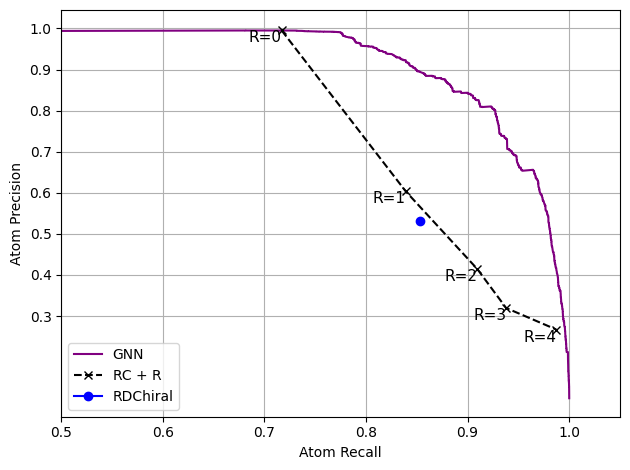

In [28]:
# RC + R stats
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.plot(
    rdchiral_metrics['recall'],
    rdchiral_metrics['precision'],
    marker='o',
    color='blue',
    label='RDChiral'
)
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Atom Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "atom_precision_recall_curve.svg", format='svg')
plt.show()

In [29]:
ep = 3e-3
dts = []
for R, prec, rec_rcr in zip(Rs, precision_from_rcr, recall_from_rcr):
    print(f"Precision | {prec:.2f}")
    argequal_prec = np.flatnonzero(np.abs(precision - prec) < ep)[:-1]
    argmax_rec = np.argmax(recall[argequal_prec])
    print(f"Recall | GNN: {recall[argequal_prec][argmax_rec]:.2f} vs RC + {R}: {rec_rcr:.2f}")
    print(f"Threshold | {thresholds[argequal_prec][argmax_rec]:.3f}\n")
    dts.append(float(thresholds[argequal_prec][argmax_rec]))

print(dts)

Precision | 1.00
Recall | GNN: 0.76 vs RC + 0: 0.72
Threshold | 0.956

Precision | 0.60
Recall | GNN: 0.97 vs RC + 1: 0.84
Threshold | 0.056

Precision | 0.41
Recall | GNN: 0.99 vs RC + 2: 0.91
Threshold | 0.015

Precision | 0.32
Recall | GNN: 0.99 vs RC + 3: 0.94
Threshold | 0.006

Precision | 0.27
Recall | GNN: 1.00 vs RC + 4: 0.99
Threshold | 0.003

[0.9562190771102905, 0.05624692514538765, 0.01461805310100317, 0.0060590095818042755, 0.0028916343580931425]


In [30]:
rxn_recall_from_rcr = []
for R in Rs:
    print(f"Calculating reaction recall from RCR for R={R}")
    preds = rcr_preds[R]
    rxn_recovery_indicator = []
    for rxn_id in tqdm(np.unique(continuous_rxn_ids), total=len(np.unique(continuous_rxn_ids)), desc="Processing reactions"):
        if (preds[continuous_rxn_ids == rxn_id] - y[continuous_rxn_ids == rxn_id] >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)
    
    rxn_recall_from_rcr.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

Calculating reaction recall from RCR for R=0


Processing reactions: 100%|██████████| 12137/12137 [04:24<00:00, 45.87it/s]


Calculating reaction recall from RCR for R=1


Processing reactions: 100%|██████████| 12137/12137 [03:59<00:00, 50.63it/s]


Calculating reaction recall from RCR for R=2


Processing reactions: 100%|██████████| 12137/12137 [03:47<00:00, 53.29it/s]


Calculating reaction recall from RCR for R=3


Processing reactions: 100%|██████████| 12137/12137 [03:46<00:00, 53.51it/s]


Calculating reaction recall from RCR for R=4


Processing reactions: 100%|██████████| 12137/12137 [03:57<00:00, 51.13it/s]


In [31]:
rxn_recall = []
ds = 1_000
for dt in tqdm(thresholds[::ds], total=len(thresholds[::ds]), desc="Calculating reaction recall from GNN"):
    rxn_recovery_indicator = []
    for rxn_id, group in pred_df.groupby("rxn_id"):
        preds = (group.y_pred >= dt).astype(np.int32).to_numpy()
        ytrue = group.y.to_numpy()
        if (preds - ytrue >= 0).all():
            rxn_recovery_indicator.append(1)
        else:
            rxn_recovery_indicator.append(0)

    rxn_recall.append(sum(rxn_recovery_indicator) / len(rxn_recovery_indicator))

Calculating reaction recall from GNN: 100%|██████████| 102/102 [03:02<00:00,  1.79s/it]


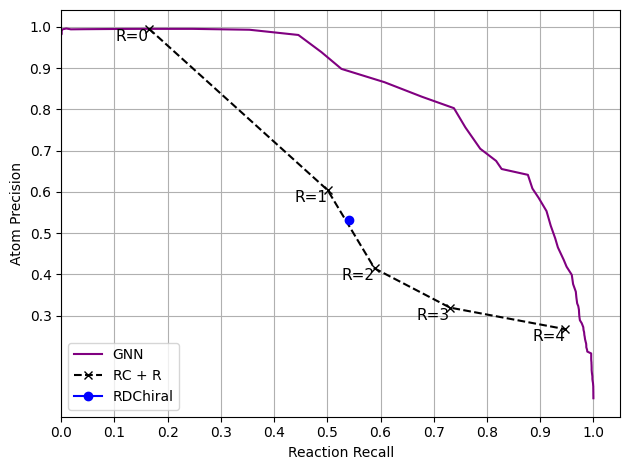

In [32]:
fig, ax = plt.subplots()
ax.plot(rxn_recall, precision[::ds], color='purple', label="GNN")
ax.plot(rxn_recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.plot(
    rdchiral_metrics['rxn_recall'],
    rdchiral_metrics['precision'],
    marker='o',
    color='blue',
    label='RDChiral'
)
ax.set_xticks(np.arange(0.0, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.0, 1.05)
ax.set_xlabel("Reaction Recall")
ax.set_ylabel("Atom Precision")
for r, p, label in zip(rxn_recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "atom_precision_reaction_recall_curve.svg", format='svg')
plt.show()

/tmp/ipykernel_401663/430326583.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_R = pred_df.groupby("min_dist_to_rc").apply(


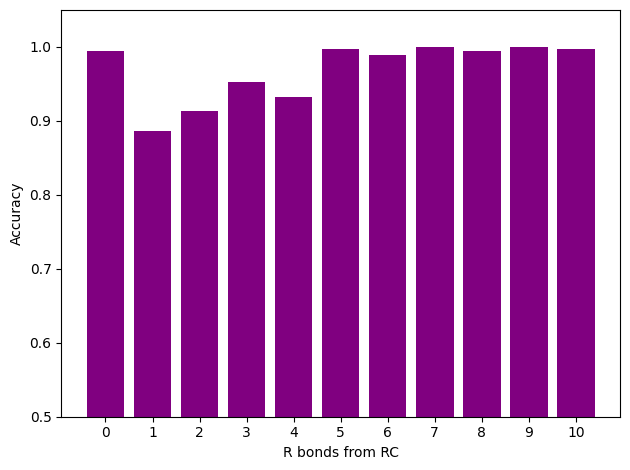

In [33]:
acc_by_R = pred_df.groupby("min_dist_to_rc").apply(
    lambda x: accuracy_score(x.y, x.y_pred >= 0.5)
).iloc[:11]

fig, ax = plt.subplots()
ax.bar(acc_by_R.index, acc_by_R.values, color='purple')
ax.set_xticks(acc_by_R.index)
ax.set_xlabel("R bonds from RC")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.5, 1.05)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "accuracy_by_R.svg", format='svg')
plt.show()

/tmp/ipykernel_401663/3533828212.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_by_rule = pred_df.groupby("rule_id").apply(


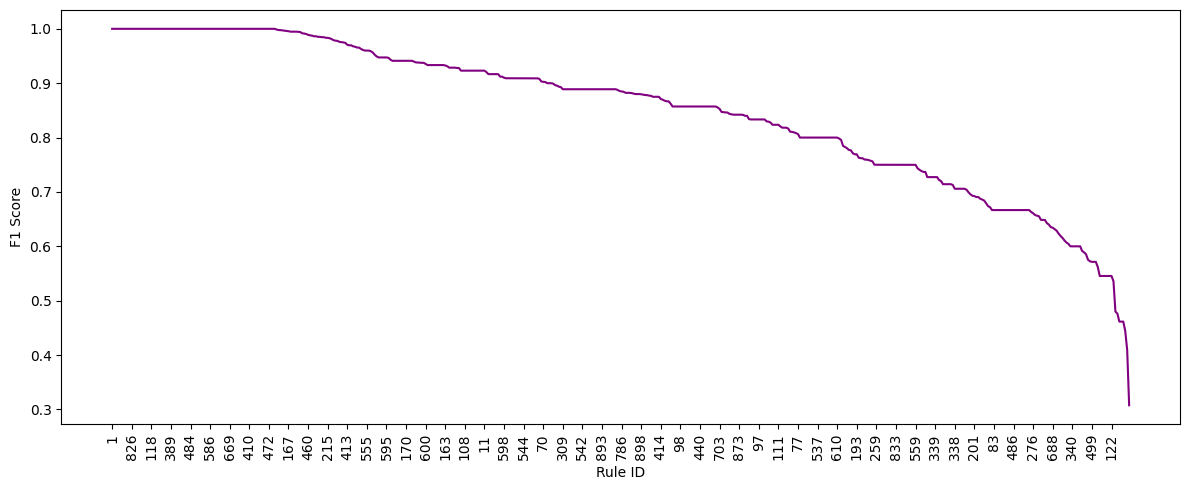

In [34]:
f1_by_rule = pred_df.groupby("rule_id").apply(
    lambda x: f1_score(x.y, x.y_pred >= 0.5)
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(f1_by_rule.values, color='purple')
ax.set_xticks(np.arange(0, len(f1_by_rule), 10))
ax.set_xticklabels(f1_by_rule.index[::10], rotation=90)
ax.set_xlabel("Rule ID")
ax.set_ylabel("F1 Score")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / "f1_by_mechinformed_rule.svg", format='svg')
plt.show()

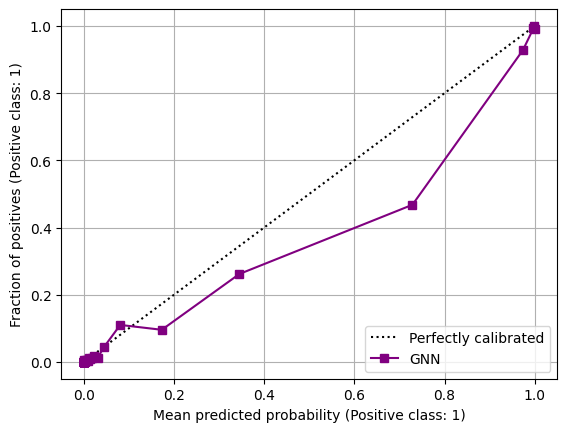

In [35]:
disp = CalibrationDisplay.from_predictions(
    pred_df.y,
    pred_df.y_pred,
    strategy="quantile",
    n_bins=50,
    name="GNN",
    color='purple',
)
plt.grid()
plt.show()